In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



['measurement', 'station']

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
inspector = inspect(engine)
tables = inspector.get_table_names(schema='main')
print(tables)

['measurement', 'station']


In [52]:
columns = {}
for t in tables:    
    cols = inspector.get_columns(t)
    print(f'Table: {t}')
    columns[t] = []
    for c in cols:
        columns[t].append(f'{t}.{c["name"]}')
        print('Column: ',c['name'], c["type"])


Table: measurement
Column:  id INTEGER
Column:  station TEXT
Column:  date TEXT
Column:  prcp FLOAT
Column:  tobs FLOAT
Table: station
Column:  id INTEGER
Column:  station TEXT
Column:  name TEXT
Column:  latitude FLOAT
Column:  longitude FLOAT
Column:  elevation FLOAT


In [92]:
# Save references to each table
measurement = Base.classes.measurement
station =  Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [58]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

<AxesSubplot:xlabel='Date'>

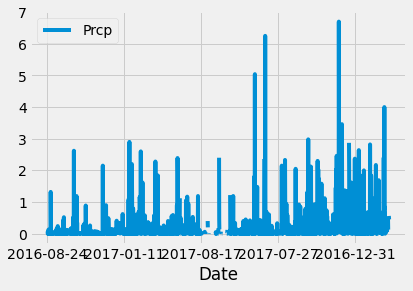

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
newest = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
oneYearLess =dt.datetime.strptime(newest, '%Y-%m-%d')-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_ly =session.query(measurement.date, measurement.prcp).filter(measurement.date > oneYearLess).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_ly_df = pd.DataFrame(data_ly,columns={'Prcp','Date'})

# Sort the dataframe by date
data_ly_df =data_ly_df.set_index('Date')
data_ly_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
data_ly_df.plot()



In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_ly_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [86]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count( measurement.station)).all()


[(19550,)]

In [91]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).\
            first()


('USC00519281', 2772)

In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel =[func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
session.query(*sel).\
    filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [96]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(measurement.date,measurement.tobs).\
    filter(measurement.date > oneYearLess).\
        filter(measurement.station == 'USC00519281').all()




[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

# Close session

In [ ]:
# Close Session
session.close()